In [17]:
from zget_data import get_responses, get_qdetails, get_questions, page_map, quest_map, attention
from collections import defaultdict
import pandas as pd
import json

In [18]:
password_response, time_response, survey_response, dids = get_responses()

Total: 163; 
Attentive: 131; Non Attentive: 32


## Password Analysis

In [19]:
pd.DataFrame(password_response)

,password2,password2_recall1,password2_recall2,password2_recall3
0,Prolific1!,NaN,NaN,NaN
1,pSVNLb85CUNPCwX,NaN,NaN,NaN
2,CozyBi11$,NaN,NaN,NaN
3,PRO333TECT,NaN,NaN,NaN
4,amandanike@91s,NaN,NaN,NaN
...,...,...,...,...
126,m0gRBn$^$V95806MS*jl,NaN,NaN,NaN
127,Ws14827!Ld,NaN,NaN,NaN
128,DCs#Bnk7,DCsBnk7,DCs#BNk7,NaN
129,4518184@@,NaN,NaN,NaN


## Time Analysis

,startstudy,fpasssurvey,pagegif,desinint,quest,csquest,motivation,spass,scog,spasssurvey,spassrecall,demo,total (mins)
0,6.993,12.491,4.413,9.111,40.826,237.705,32.419,15.948,26.032,15.129,49.566,89.285,8.998633
1,5.839,13.774,12.693,19.878,67.504,134.684,15.391,25.888,13.926,19.650,9.519,48.709,6.457583
2,5.174,11.211,6.987,15.680,36.149,110.712,12.244,35.100,16.638,24.316,8.088,28.816,5.185250
3,1.664,22.872,3.551,5.522,43.416,115.263,2.750,48.463,7.047,17.072,15.119,96.297,6.317267
4,5.599,32.481,11.720,71.919,137.019,206.751,27.432,90.620,21.551,33.020,33.760,57.601,12.157883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,10.974,12.813,6.607,20.575,37.760,153.590,19.337,30.086,9.032,19.466,7.269,30.913,5.973700
127,9.237,27.703,7.435,29.832,65.615,189.192,36.536,75.067,13.396,31.367,27.890,45.550,9.313667
128,13.409,19.102,38.229,68.628,95.781,210.613,20.121,48.992,14.261,36.459,99.563,27.472,11.543833
129,6.618,15.085,8.383,41.453,52.419,149.316,12.804,17.694,14.235,24.838,8.208,32.223,6.387933


11.246677862595428

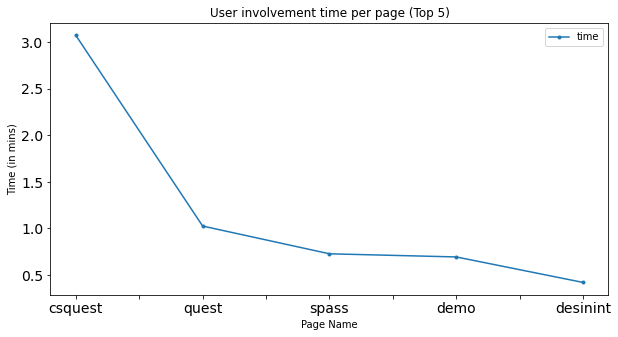

In [20]:
page_time_df = pd.DataFrame(time_response)
page_time_df = page_time_df.sort_index(axis=1, key=lambda x: x.astype(int))
page_time_df = page_time_df.rename(page_map, axis=1)
page_time_df['total (mins)'] = page_time_df.sum(axis=1)/60
display(page_time_df)
display(page_time_df['total (mins)'].mean())



# top 5 pages with higher time
top5 = pd.DataFrame(columns=['page', 'time'])
for i, data in page_time_df.median().div(60).sort_values(ascending=False).head(5).items():
    top5 = pd.concat([top5, pd.DataFrame([[i, data]], columns=top5.columns)])

_ = top5.plot(x='page', y='time', figsize=(10, 5), xlabel="Page Name", ylabel="Time (in mins)", title="User involvement time per page (Top 5)", fontsize=14, style=".-")

## Survey Response Analysis

In [21]:
questions = get_questions()
survey_response_df = pd.DataFrame(survey_response)
display(survey_response_df.head(1))

survey_response_df['did'] = dids
survey_response_df.groupby(by='did').size().reset_index(name='counts')

,8,12,3,7,14
0,"{'5-1': '5', '6-1': '1', '7-1': '6', '8-1': ['...","{'1-1': '6', '2-1': '5', '3-1': '1', '3-2': '2...","{'1-1': '7', '1-2': '2', '1-3': '1', '1-4': '1'}","{'1-17': '1', '1-16': '7', '1-12': '3', '1-13'...","{'1-1': 'Man', '2-1': '25-29 years old', '3-1'..."


,did,counts
0,1,27
1,2,26
2,3,26
3,4,26
4,5,26


### Quest

In [22]:
normqsid = ['1-2', '1-4', '1-7', '1-10', '1-12', '1-13', '1-16']
quest = pd.DataFrame(survey_response_df['7'].to_dict()).astype(int)
quest.drop(attention.get('7'), inplace=True)
normquest = 8 - quest.loc[normqsid]
quest.update(normquest)

new_index = {}
for qsid in quest.index:
    likert_scale = 'low' if qsid in normqsid else 'high'
    new_index[qsid] = json.loads(get_qdetails('7', qsid).replace("'", '"')).get('elements').get(likert_scale)
new_index
quest = quest.rename(new_index)
quest['mean'] = quest.mean(axis=1)
quest['median'] = quest.median(axis=1)
quest

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,mean,median
organized,1.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,6.0,5.0,4.0,6.0,5.0,5.0,6.0,6.0,5.740458,6.0
ordered,1.0,6.0,7.0,7.0,7.0,1.0,7.0,7.0,7.0,7.0,...,6.0,5.0,5.0,6.0,5.0,5.0,6.0,7.0,5.458015,6.0
beneficial,5.0,5.0,6.0,6.0,7.0,3.0,7.0,2.0,7.0,7.0,...,6.0,6.0,6.0,7.0,7.0,5.0,5.0,7.0,5.480916,6.0
rewarding,3.0,2.0,5.0,7.0,7.0,4.0,7.0,2.0,4.0,6.0,...,6.0,4.0,3.0,4.0,5.0,4.0,5.0,6.0,4.801527,5.0
well grouped,1.0,6.0,7.0,6.0,7.0,5.0,7.0,7.0,7.0,7.0,...,6.0,5.0,6.0,6.0,5.0,5.0,6.0,7.0,5.580153,6.0
structured,1.0,6.0,6.0,6.0,7.0,6.0,7.0,7.0,7.0,7.0,...,6.0,6.0,5.0,7.0,5.0,5.0,5.0,6.0,5.778626,6.0
helpful,4.0,5.0,7.0,7.0,7.0,7.0,7.0,2.0,7.0,7.0,...,6.0,6.0,5.0,6.0,6.0,4.0,6.0,6.0,5.625954,6.0
clear,2.0,6.0,7.0,3.0,7.0,2.0,7.0,7.0,7.0,7.0,...,6.0,7.0,6.0,7.0,6.0,5.0,7.0,6.0,5.503817,6.0
useful,5.0,5.0,6.0,6.0,7.0,2.0,7.0,2.0,7.0,7.0,...,6.0,6.0,7.0,6.0,7.0,3.0,6.0,7.0,5.320611,6.0
appealing,1.0,1.0,5.0,6.0,6.0,5.0,7.0,2.0,6.0,6.0,...,6.0,5.0,6.0,4.0,6.0,5.0,5.0,7.0,5.282443,6.0


In [23]:
cats = {}
for k, v in quest_map.items():
    temp = quest.loc[v]
    cats[k] = temp

for k, v in cats.items():
    print(f'{k}: {v["mean"].mean()}')

for k, v in cats.items():
    print(f'{k}: {v["median"].median()}')

Perspicuity: 5.662213740458015
Aesthetics: 5.009541984732825
Usefulness: 5.307251908396946
Clarity: 5.6393129770992365
Perspicuity: 6.0
Aesthetics: 5.0
Usefulness: 6.0
Clarity: 6.0


### CSQuest

In [24]:
csquest = pd.DataFrame(survey_response_df['8'].to_dict())
qualindex = ['8-1', '10-1', '11-1']
csquestqual = csquest.loc[qualindex]
csquestqual

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
8-1,"[Social Media, Financial Websites, Course Mana...",[None of the above],"[Social Media, Email, Financial Websites, Cour...","[Social Media, Email]","[Social Media, Financial Websites, E-commerce ...","[Social Media, Email]","[Social Media, Email, E-commerce Websites, Cou...",[None of the above],"[Social Media, Email, Financial Websites, Gami...","[Social Media, Email, Financial Websites, E-co...",...,"[Social Media, Email]","[Social Media, Gaming Websites, E-commerce Web...","[Social Media, Email, Financial Websites, Gami...","[Social Media, Financial Websites, Gaming Webs...","[Social Media, Email, Financial Websites, E-co...","[Financial Websites, E-commerce Websites, Gove...","[Email, Financial Websites, E-commerce Website...","[Social Media, Email, Financial Websites, Gove...","[Social Media, Financial Websites, E-commerce ...","[Social Media, Financial Websites, E-commerce ..."
10-1,Thinking about my info being hacked into,"I guess the last panel, which shows how easy i...",The possibility of it showing a threat by only...,THE LAST PART IS REALLT MOTIVATES TO MAKE A ST...,81% of data breaches in 2020 happened due to w...,ALB*1988,Clean style with a very straight to the point ...,"Mainly the child asking the dad what he did, s...",The part where it takes over the account and s...,The hacker can't hack that system while creati...,...,the hacker makes me want to make a really stro...,I realize that password will be see it was ama...,The part where the hacker sends out the virus ...,Knowing how many people have their data compro...,THE PASSWORDS CAN BE EASILY ACCESSBLE ONE TO A...,The statistics stating the actual numbers of p...,The hacker's screen saying attack successful a...,The second part motives me most to create a st...,where it show that 4 out of 10 people use weak...,I am thinking of installing a hard password fo...
11-1,That if I have an insecure password my identit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The dartboard represents the difficulty level ...,...,the stronger your password is the more inner t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
csquestquant = csquest.drop(qualindex).fillna(0).astype(int)
csquestquant.drop(attention.get('8'), inplace=True)

normqsid = []
normcsquestquant = 8 - csquestquant.loc[normqsid]
csquestquant.update(normquest)

new_index = {}
for qsid in csquestquant.index:
    new_index[qsid] = json.loads(get_qdetails('8', qsid).replace("'", '"').split('\n')[1]).get('title')
new_index
csquestquant = csquestquant.rename(new_index)
csquestquant['mean'] = csquestquant.mean(axis=1)
csquestquant['median'] = csquestquant.median(axis=1)

csquestquant

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,mean,median
portrayal of hacker stimulates,5.0,1.0,5.0,6.0,0.0,5.0,7.0,1.0,7.0,7.0,...,7.0,0.0,7.0,0.0,6.0,5.0,0.0,0.0,4.198473,5.000000
portrayal of victim encourages,6.0,5.0,5.0,4.0,0.0,6.0,7.0,5.0,7.0,4.0,...,6.0,0.0,6.0,0.0,6.0,5.0,0.0,0.0,4.190840,5.000000
Makes me worried,3.0,1.0,6.0,5.0,1.0,5.0,6.0,2.0,5.0,7.0,...,5.0,2.0,5.0,1.0,1.0,4.0,4.0,2.0,4.427481,5.000000
Encourages me to create a strong password,3.0,4.0,6.0,7.0,6.0,4.0,6.0,4.0,7.0,7.0,...,7.0,7.0,7.0,4.0,1.0,6.0,5.0,6.0,5.610687,6.000000
Makes me feel emotionally connected to the presented scenario,1.0,1.0,3.0,5.0,5.0,6.0,5.0,1.0,1.0,7.0,...,5.0,5.0,6.0,1.0,2.0,4.0,5.0,5.0,4.694656,5.000000
Makes me feel personally connected to the presented scenario,1.0,1.0,2.0,6.0,7.0,5.0,6.0,1.0,5.0,7.0,...,5.0,5.0,7.0,1.0,1.0,4.0,6.0,7.0,4.732824,5.000000
easy to follow,2.0,7.0,7.0,5.0,6.0,6.0,7.0,7.0,7.0,7.0,...,7.0,7.0,6.0,6.0,1.0,5.0,5.0,6.0,5.671756,6.000000
Novel,5.0,1.0,1.0,4.0,7.0,6.0,6.0,2.0,4.0,6.0,...,6.0,4.0,5.0,4.0,4.0,6.0,5.0,7.0,4.839695,5.000000
Attractive,2.0,6.0,7.0,3.0,7.0,2.0,7.0,7.0,7.0,7.0,...,6.0,7.0,6.0,7.0,6.0,5.0,7.0,6.0,5.503817,6.000000
Informative,4.0,5.0,6.0,6.0,6.0,6.0,7.0,2.0,7.0,7.0,...,7.0,6.0,7.0,6.0,3.0,5.0,6.0,6.0,5.526718,6.000000


### First Password Survey

In [26]:
normqsid = []
fpass = pd.DataFrame(survey_response_df['3'].to_dict()).astype(int)
normfpass = 8 - fpass.loc[normqsid]
fpass.update(normfpass)
fpass

new_index = {}
for qsid in fpass.index:
    likert_scale = 'low' if qsid in normqsid else 'high'
    new_index[qsid] = json.loads(get_qdetails('3', qsid).replace("'", '"').split('\n')[1]).get('title')
new_index
fpass = fpass.rename(new_index)
fpass['mean'] = fpass.mean(axis=1)
fpass['median'] = fpass.median(axis=1)
fpass

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,mean,median
"I do not change my passwords, unless I have to.",7,6,7,4,5,5,4,7,3,5,...,2,6,4,2,5,4,6,7,5.053435,5.0
I use different passwords for different online accounts that I have.,2,7,1,6,7,7,5,7,7,7,...,7,6,5,7,6,6,5,6,5.480916,6.0
"When I create a new online account, I try to use a password that goes beyond the site’s minimum requirements.",1,7,3,5,6,6,4,7,5,7,...,6,7,6,7,6,6,6,7,5.122137,5.0
I do not include special characters in my password if it’s not required.,1,1,5,1,1,6,7,1,1,3,...,2,2,3,1,1,2,2,6,3.213740,3.0


### Second Password Survey

In [27]:
normqsid = []
spass = pd.DataFrame(survey_response_df['12'].to_dict()).astype(int)
spass.drop(attention.get('12'), inplace=True)
normspass = 8 - spass.loc[normqsid]
spass.update(normspass)

new_index = {}
for qsid in spass.index:
    # likert_scale = 'low' if qsid in normqsid else 'high'
    new_index[qsid] = json.loads(get_qdetails('12', qsid).replace("'", '"').split('\n')[1]).get('title')
new_index
spass = spass.rename(new_index)
spass['mean'] = spass.mean(axis=1)
spass['median'] = spass.median(axis=1)
spass

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,mean,median
strength of password,6,7,6,6,7,6,5,6,7,7,...,7,6,7,7,6,6,5,7,5.877863,6.000000
motivated after going through design,5,1,6,7,7,5,6,4,7,7,...,7,7,6,4,7,6,6,6,5.755725,6.000000
Hard to remember,1,7,2,6,6,6,4,3,1,1,...,3,2,4,7,7,5,3,7,4.305344,4.152672
Can be easily guessed by a hacker,2,1,3,1,1,5,4,1,1,1,...,1,2,2,1,1,2,3,6,2.961832,2.000000
Can be easily guessed by my close friends or family members,1,1,1,1,1,7,1,1,1,2,...,1,1,1,1,1,2,4,7,2.702290,2.000000
Stronger than the passwords I usually use,3,4,6,6,7,6,6,4,4,6,...,4,2,6,2,5,3,2,6,4.763359,5.000000


### Demographics

In [28]:
demo = pd.DataFrame(survey_response_df['14'].to_dict())

new_index = {}
for qsid in demo.index:
    new_index[qsid] = get_qdetails('14', qsid, 'keyword').split('\n')[0]

demo = demo.rename(new_index).transpose()
demo.head()

,gender,age,race,highest education,education field,occupation,tech experience,cyber experience
0,Man,25-29 years old,[White],Four-year College Degree,"Computer Science/Engineering, and Information ...",Business or industry,Pursuing or completed a degree,Pursuing or completed a degree
1,Man,35-39 years old,[Hispanic or Latino],High School Graduate,"Medicine, Nursing, and Health Sciences",Business or industry,Self-taught,No experience
2,Man,18-24 years old,[White],Four-year College Degree,"Mathematics, and Natural Sciences (Physics, Ch...",Unemployed,No experience,No experience
3,Woman,30-34 years old,[White],Four-year College Degree,Other areas of Engineering,Non-profit organization,Pursuing or completed a degree,Formal training
4,Man,35-39 years old,[Native American or American Indian],Four-year College Degree,Business,Business or industry,Pursuing or completed a degree,Formal training


In [29]:
# display(demo['gender'].value_counts())
# display(demo['race'].value_counts())
# display(demo['highest education'].value_counts())
# display(demo['tech experience'].value_counts())
# display(demo['cyber experience'].value_counts())